In [1]:
import matplotlib as mpl

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ptitprince as pt

%matplotlib inline

In [2]:
mpl.rcParams['figure.dpi'] = 300

# Benchmark: Stand-alone versus Composed binary

A node is created that subscribes to the `/image_raw` topic provided by our [camera driver](https://gitlab.com/boldhearts/ros2_v4l2_camera). The node applies a Sobel gradient operation to incur
some actual processing cost to offset overhead costs against, and measures the time from initial image capture (provided in the `Image` header) until it finished processing the image. The code is in the [ros2_benchmark](https://gitlab.com/boldhearts/ros2_v4l2_camera) repository.

## Case 1: Compare without any optimization

### Load data

In [3]:
with open("data/standalone-timings.txt", "r") as f:
    standalone_data = f.read()

In [4]:
with open("data/composed-timings.txt", "r") as f:
    composed_data = f.read()

In [5]:
standalone_dts = np.array([int(l) for l in standalone_data.strip().split("\n") if l != ""])

In [6]:
composed_dts = np.array([int(l) for l in composed_data.strip().split("\n") if l != ""])

In [7]:
print(f"Number of stand-alone datapoints: {len(standalone_dts):,}")

Number of stand-alone datapoints: 1,362


In [8]:
print(f"Number of composed datapoints: {len(composed_dts):,}")

Number of composed datapoints: 2,826


### Prepare data
The timings are in nanoseconds, they are transformed to milliseconds to be easier to interpret. We also take 1,000 samples from each set, discarding the first 200 to not include any startup effects.

In [9]:
standalone_dts_sample = standalone_dts[200:1200] / 1e6
composed_dts_sample = composed_dts[200:1200] / 1e6

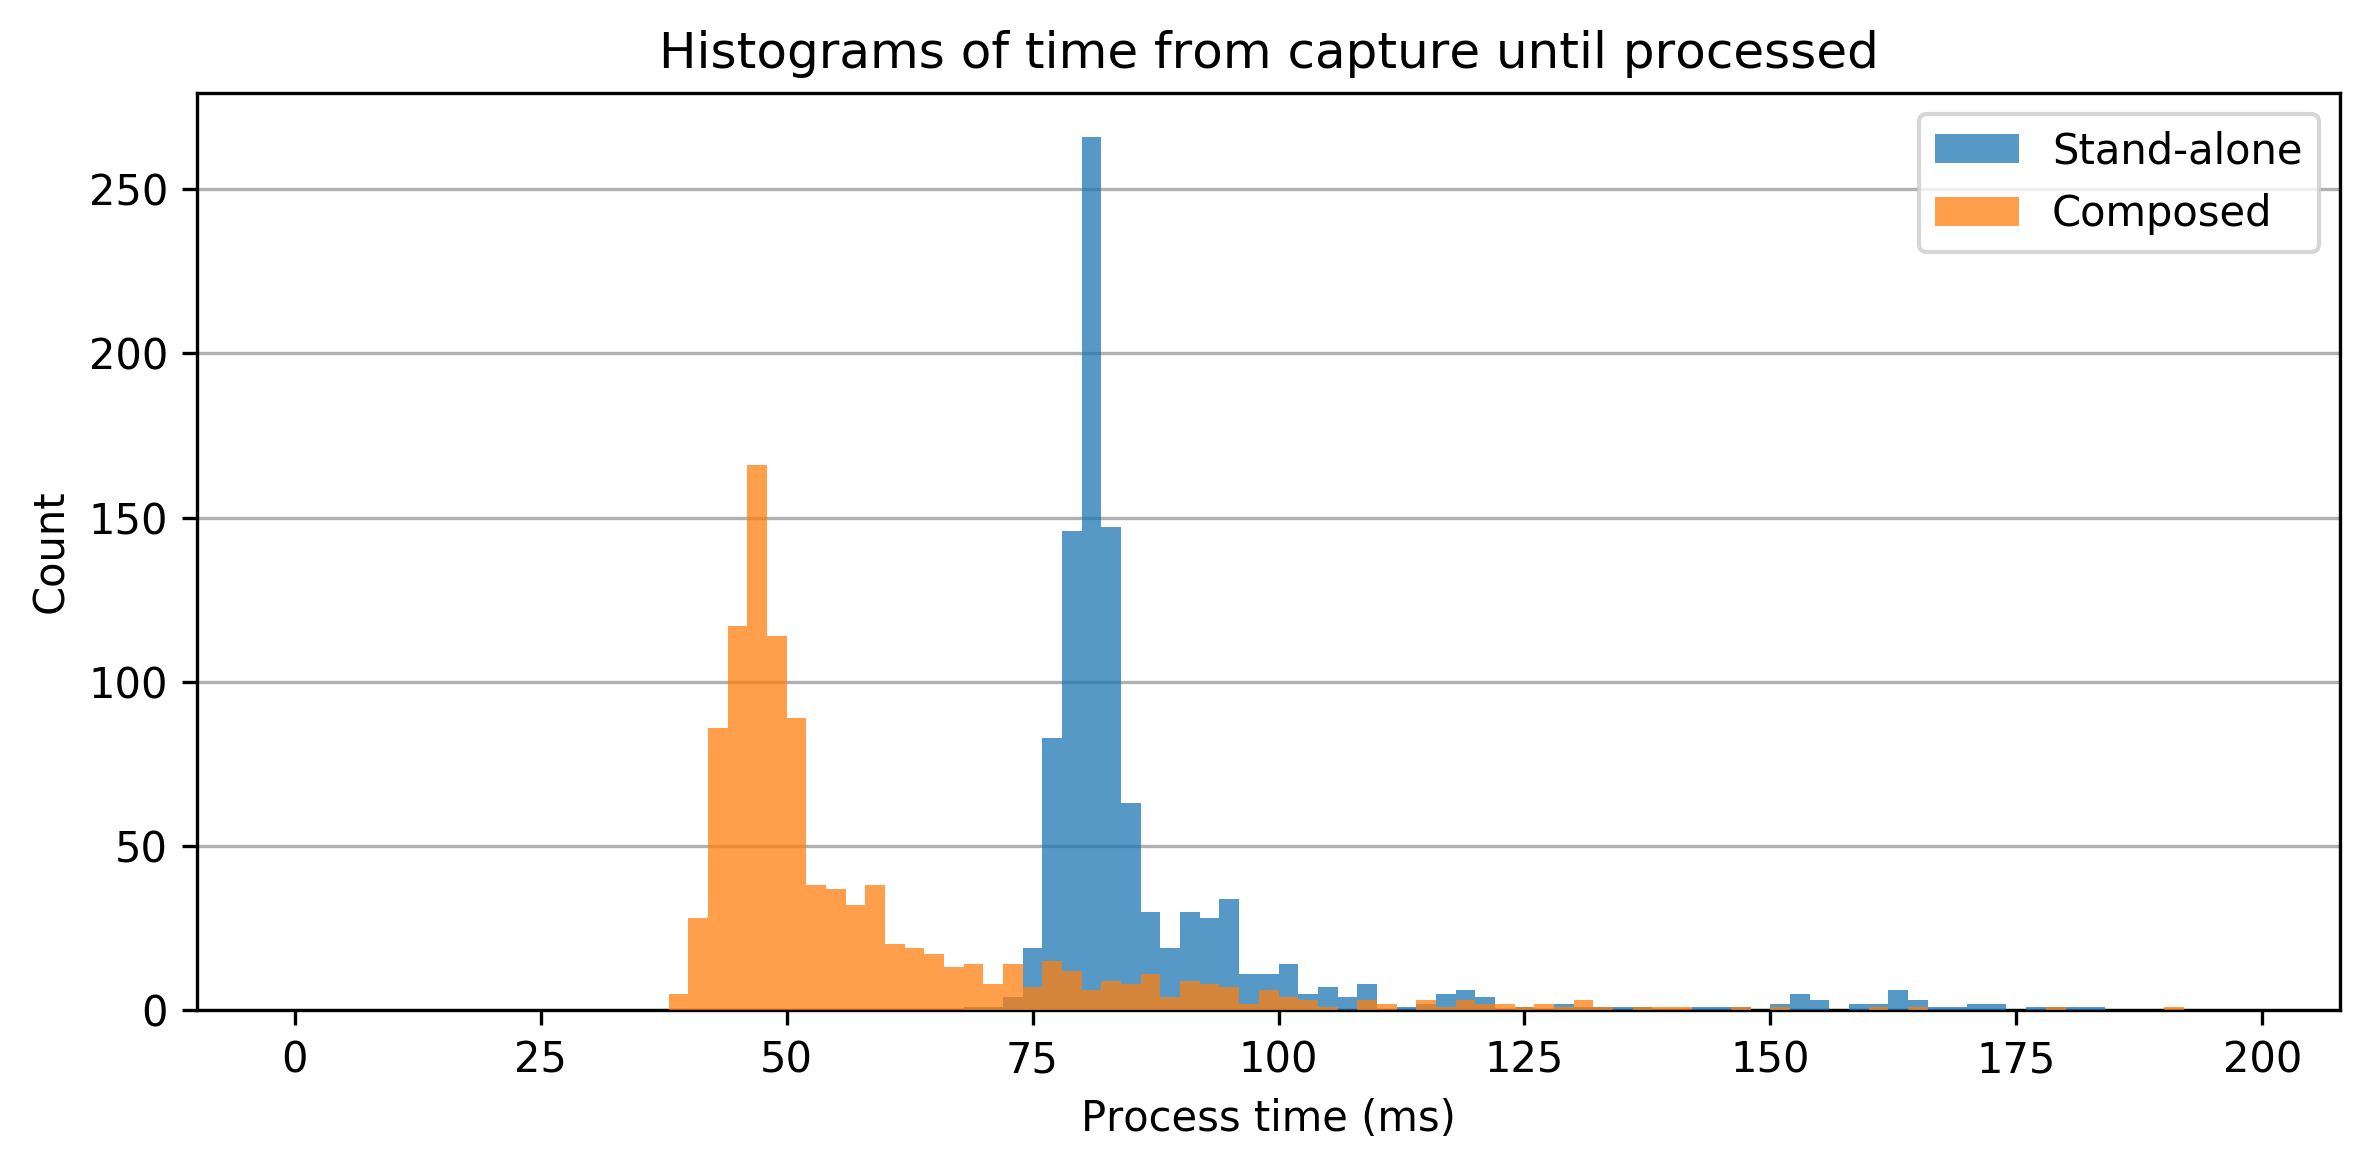

In [10]:
plt.figure(figsize=(8, 4))
plt.hist(standalone_dts_sample, bins=range(0, 200, 2), label="Stand-alone", alpha=.75, zorder=3)
plt.hist(composed_dts_sample, bins=range(0, 200, 2), label="Composed", alpha=.75, zorder=3)
plt.grid(axis='y', zorder=1)
plt.legend()
plt.title("Histograms of time from capture until processed")
plt.xlabel("Process time (ms)")
plt.ylabel("Count")
plt.tight_layout()

In [11]:
df = pd.DataFrame({
    'x': ["Stand-alone"] * 1000 + ["Composed"] * 1000,
    'y': list(standalone_dts_sample) + list(composed_dts_sample)
})

#### Distribution of image processing time (RainCloud)

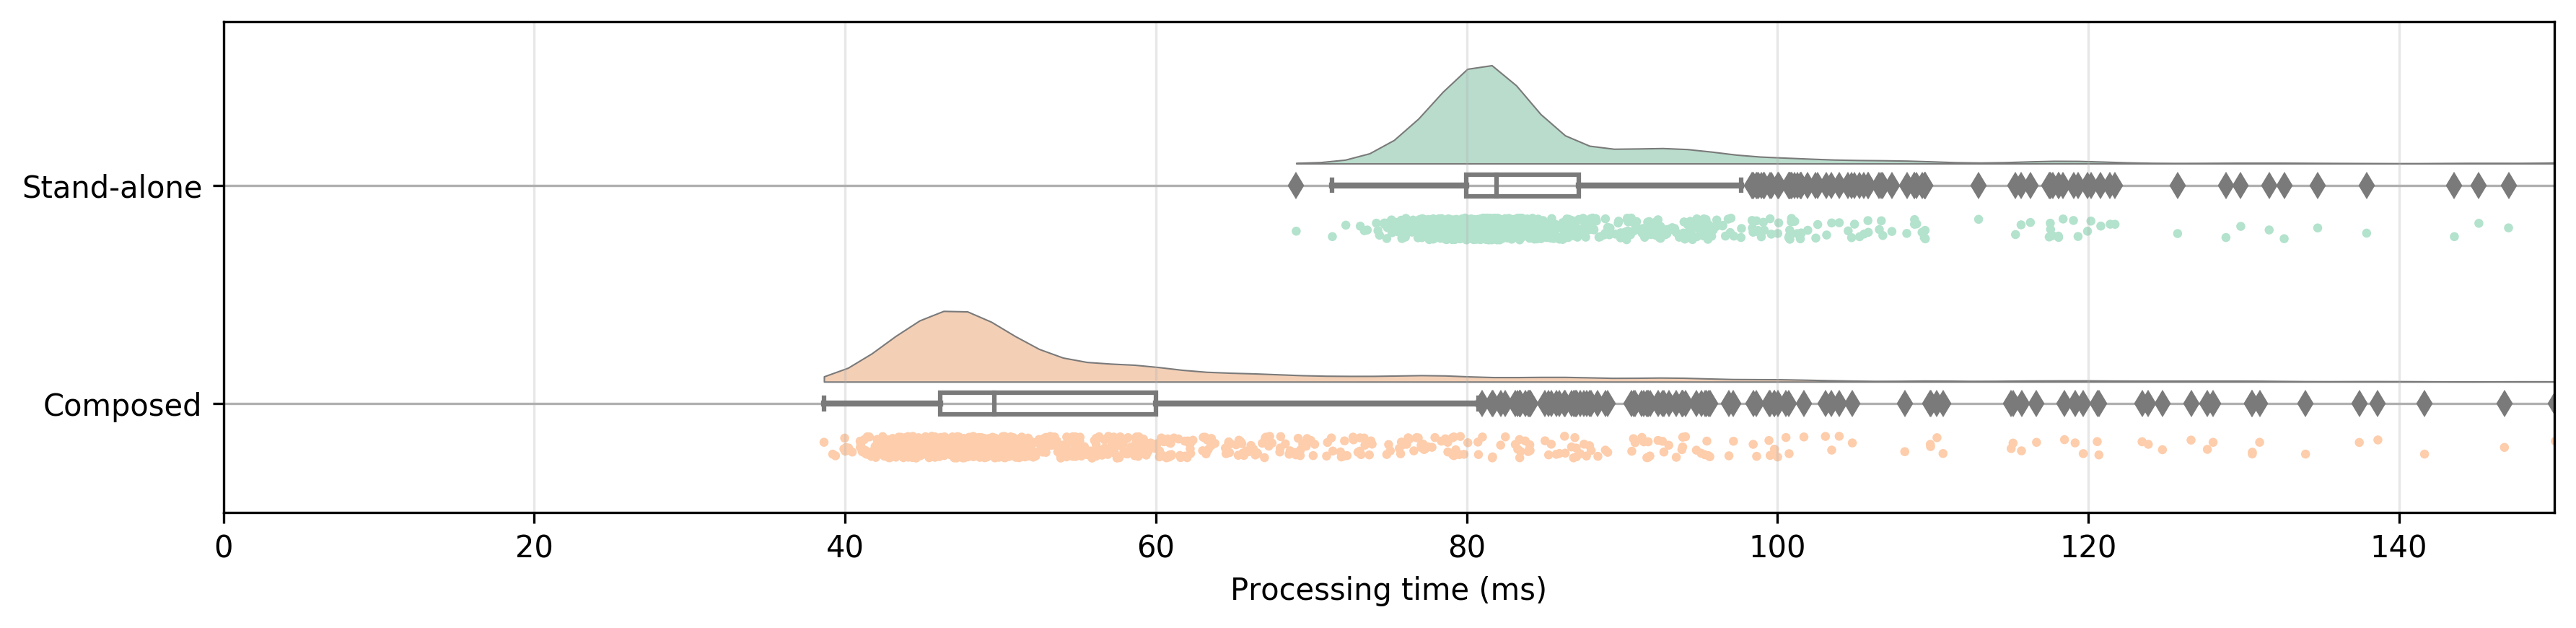

In [12]:
pt.RainCloud(data=df, x='x', y='y', bw = 0.1, palette='Pastel2',
             linewidth=0.5,
             width_viol = .9,
             jitter=.05,
             width_box = .1,
             offset= .1,
             figsize = (12,3), orient = 'h',
             move = .2)
plt.xlim((0, 150))
# plt.title("Distribution of image processing time")
plt.xlabel("Processing time (ms)")
# plt.xlabel("")
plt.ylabel(None)
plt.grid(axis='y')
plt.grid(axis='x', alpha=.3)
plt.tight_layout()
plt.savefig("standalone-vs-composed.pdf")

In [13]:
print(f"Median time, stand-alone: {np.median(standalone_dts_sample)}ms")

Median time, stand-alone: 81.92369ms


In [14]:
print(f"Median time, composed: {np.median(composed_dts_sample)}ms")

Median time, composed: 49.6238995ms


## Case 2: Compare with compiler optimization

The ROS 2 installation as well as all packages have been built using GCC's optimization level 3, e.g., `colcon build --cmake-args -DCMAKE_BUILD_TYPE=Release`.

### Load data

In [15]:
with open("data/standalone-timings-full-RELEASE-10000.txt", "r") as f:
    standalone_data = f.read()
with open("data/composed-noipc-timings-full-RELEASE-10000.txt", "r") as f:
    composed_noipc_data = f.read()
with open("data/composed-timings-full-RELEASE-10000.txt", "r") as f:
    composed_data = f.read()

In [16]:
standalone_dts = np.array([int(l) for l in standalone_data.strip().split("\n") if l != ""])
composed_noipc_dts = np.array([int(l) for l in composed_noipc_data.strip().split("\n") if l != "" and int(l) < 1e9])
composed_dts = np.array([int(l) for l in composed_data.strip().split("\n") if l != ""])


In [17]:
print(f"Number of stand-alone datapoints: {len(standalone_dts):,}")

Number of stand-alone datapoints: 11,815


In [18]:
print(f"Number of composed no-IPC datapoints: {len(composed_noipc_dts):,}")

Number of composed no-IPC datapoints: 11,805


In [19]:
print(f"Number of composed datapoints: {len(composed_dts):,}")

Number of composed datapoints: 15,019


## Prepare data

Again the timings are transformed to milliseconds. Although the sets are significantly longer, we pick again 18.500 for seeing a better effect.

In [20]:
standalone_dts_sample = standalone_dts[200:10200] / 1e6
composed_noipc_dts_sample = composed_noipc_dts[200:10200] / 1e6
composed_dts_sample = composed_dts[200:10200] / 1e6

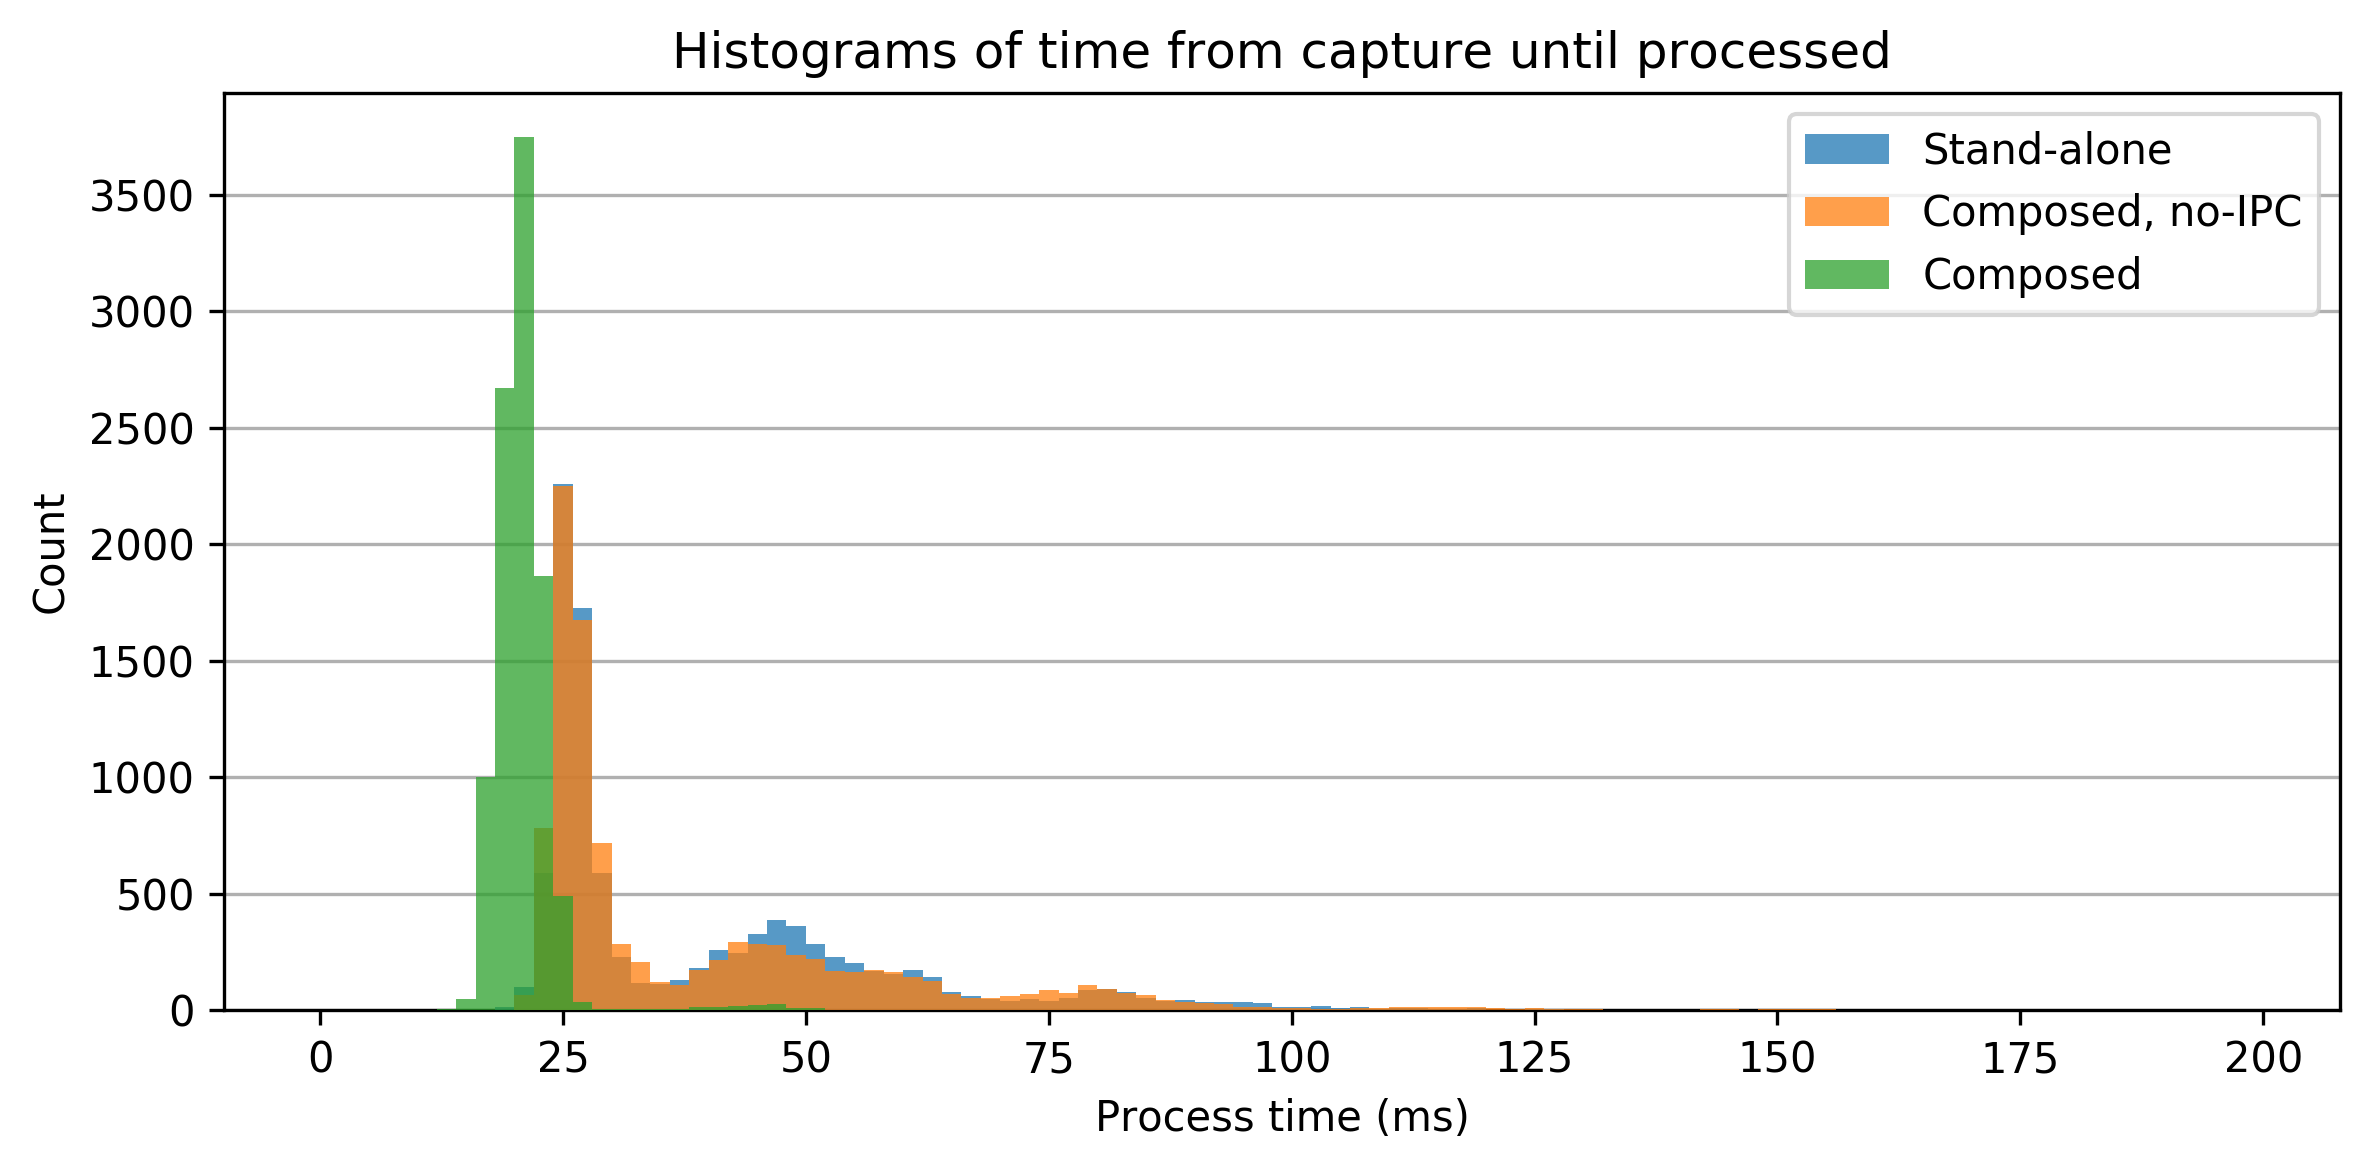

In [21]:
plt.figure(figsize=(8, 4))
plt.hist(standalone_dts_sample, bins=range(0, 200, 2), label="Stand-alone", alpha=.75, zorder=3)
plt.hist(composed_noipc_dts_sample, bins=range(0, 200, 2), label="Composed, no-IPC", alpha=.75, zorder=3)
plt.hist(composed_dts_sample, bins=range(0, 200, 2), label="Composed", alpha=.75, zorder=3)
plt.grid(axis='y', zorder=1)
plt.legend()
plt.title("Histograms of time from capture until processed")
plt.xlabel("Process time (ms)")
plt.ylabel("Count")
plt.tight_layout()

In [22]:
df = pd.DataFrame({
    'x': ["Stand-alone"] * 10000 + ["Composed, no-IPC"] * 10000 + ["Composed, IPC"] * 10000,
    'y': list(standalone_dts_sample) + list(composed_noipc_dts_sample) + list(composed_dts_sample)
})

#### Distribution of image processing time (RainCloud)

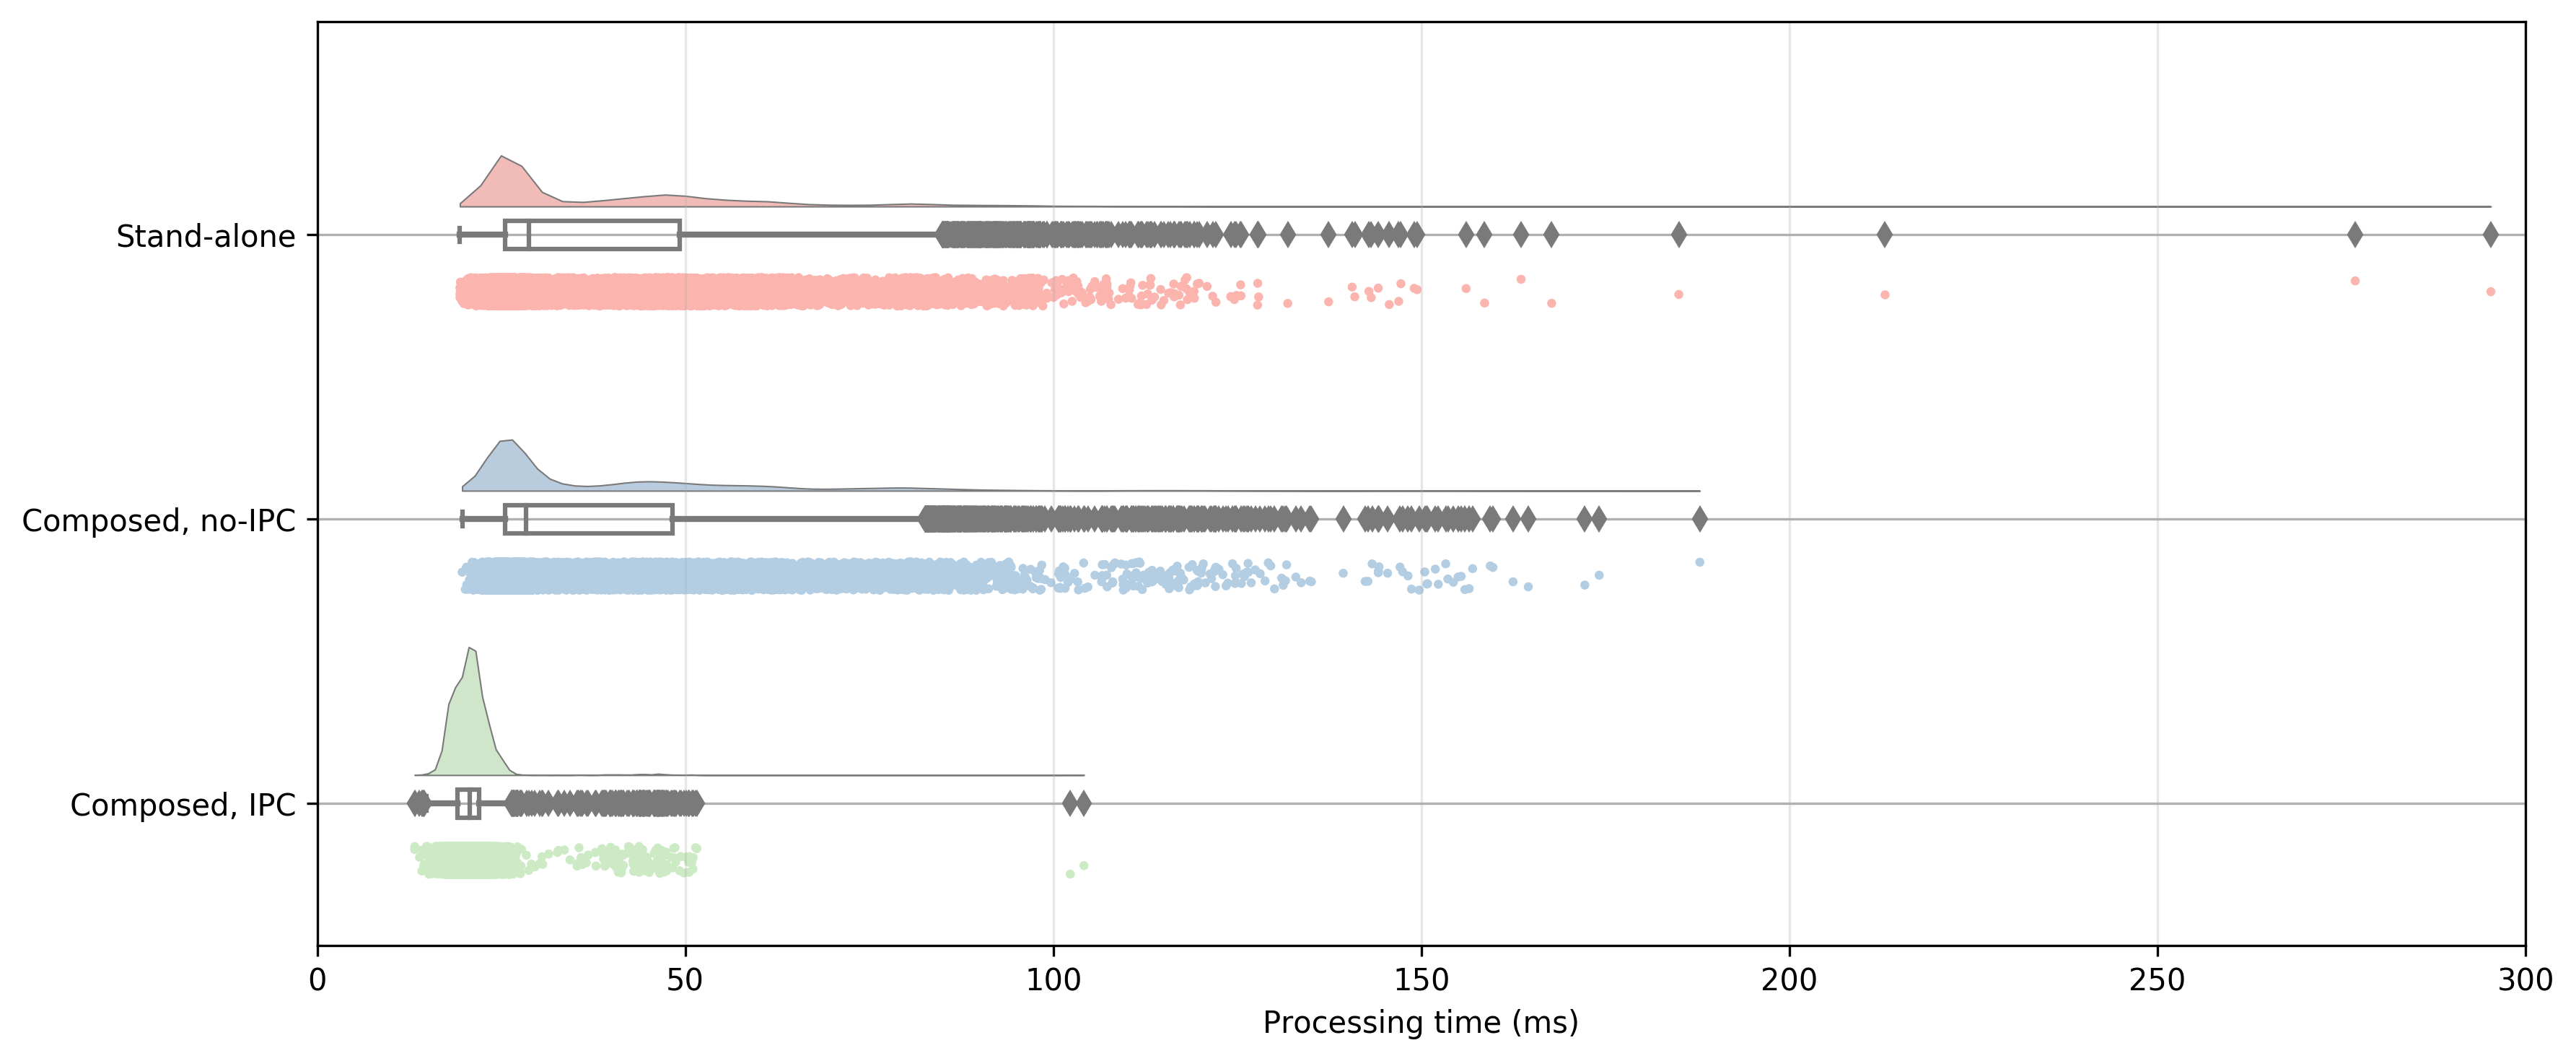

In [23]:
pt.RainCloud(data=df, x='x', y='y', bw = 0.1, palette='Pastel1',
             linewidth=0.5,
             width_viol = .9,
             jitter=.05,
             width_box = .1,
             offset= .1,
             figsize = (12,5), orient = 'h',
             move = .2)
plt.xlim((0, 300))
# remove for better include in Paper
#plt.title("Distribution of image processing time")
plt.xlabel("Processing time (ms)")
plt.ylabel(None)
plt.grid(axis='y')
plt.grid(axis='x', alpha=.3)
plt.tight_layout()
plt.savefig("standalone-vs-composed-Release.pdf")

In [24]:
print(f"Median time, stand-alone: {np.median(standalone_dts_sample)}ms")
print(f"Median time, composed, no-IPC: {np.median(composed_noipc_dts_sample)}ms")
print(f"Median time, composed: {np.median(composed_dts_sample)}ms")

Median time, stand-alone: 28.736299ms
Median time, composed, no-IPC: 28.4157175ms
Median time, composed: 20.741411999999997ms


In [37]:
np.median(composed_dts_sample) / np.median(standalone_dts_sample)

0.6654591695794666

In [25]:
print(f"Mean time, stand-alone: {np.mean(standalone_dts_sample)}ms")
print(f"Mean time, composed, no-IPC: {np.mean(composed_noipc_dts_sample)}ms")
print(f"Mean time, composed: {np.mean(composed_dts_sample)}ms")

Mean time, stand-alone: 39.7310733848ms
Mean time, composed, no-IPC: 39.4736354071ms
Mean time, composed: 20.9584686961ms


## Case 3: Compare with compiler optimization and while other nodes are running

We increase the node communication with subscribing also to `/imu/data` and `/joint_states` topic. 

### Load data

In [26]:
with open("data/standalone-mn-timings-full-RELEASE-10000.txt", "r") as f:
    standalone_data = f.read()
with open("data/composed-mn-noipc-timings-full-RELEASE-10000.txt", "r") as f:
    composed_noipc_data = f.read()
with open("data/composed-mn-timings-full-RELEASE-10000.txt", "r") as f:
    composed_data = f.read()

In [27]:
standalone_dts = np.array([int(l) for l in standalone_data.strip().split("\n") if l != ""])
composed_noipc_dts = np.array([int(l) for l in composed_noipc_data.strip().split("\n") if l != "" and int(l) < 1e9])
composed_dts = np.array([int(l) for l in composed_data.strip().split("\n") if l != ""])


In [28]:
print(f"Number of stand-alone datapoints: {len(standalone_dts):,}")

Number of stand-alone datapoints: 10,886


In [29]:
print(f"Number of composed no-IPC datapoints: {len(composed_noipc_dts):,}")

Number of composed no-IPC datapoints: 11,832


In [30]:
print(f"Number of composed datapoints: {len(composed_dts):,}")

Number of composed datapoints: 10,922


### Prepare data

Transform to milliseconds, avoid start up effects.

In [31]:
standalone_dts_sample = standalone_dts[200:10200] / 1e6
composed_noipc_dts_sample = composed_noipc_dts[200:10200] / 1e6
composed_dts_sample = composed_dts[200:10200] / 1e6

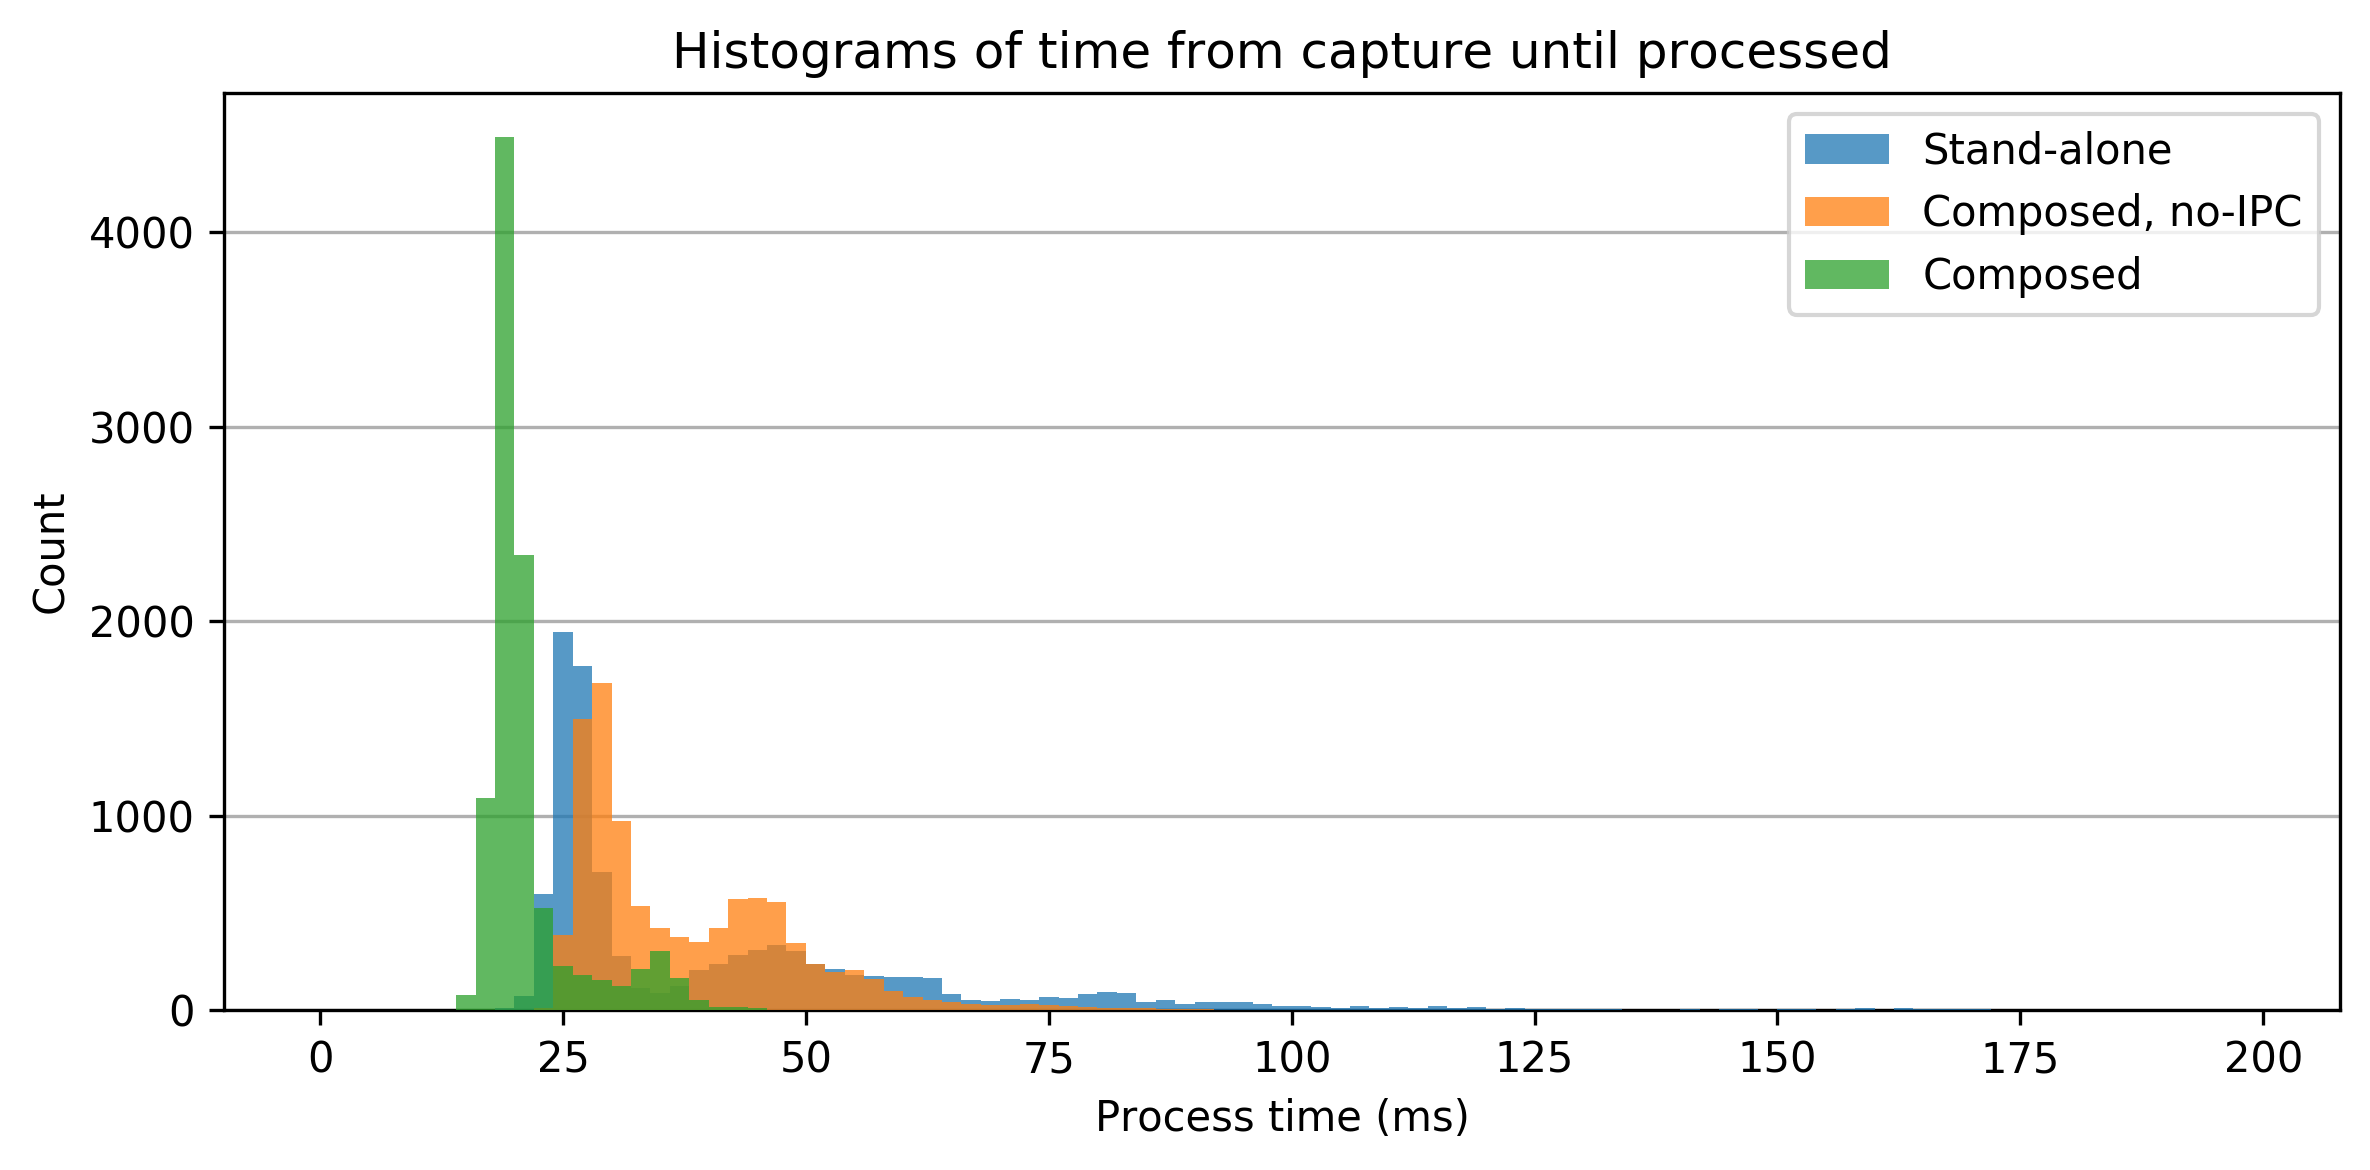

In [32]:
plt.figure(figsize=(8, 4))
plt.hist(standalone_dts_sample, bins=range(0, 200, 2), label="Stand-alone", alpha=.75, zorder=3)
plt.hist(composed_noipc_dts_sample, bins=range(0, 200, 2), label="Composed, no-IPC", alpha=.75, zorder=3)
plt.hist(composed_dts_sample, bins=range(0, 200, 2), label="Composed", alpha=.75, zorder=3)
plt.grid(axis='y', zorder=1)
plt.legend()
plt.title("Histograms of time from capture until processed")
plt.xlabel("Process time (ms)")
plt.ylabel("Count")
plt.tight_layout()

In [33]:
df = pd.DataFrame({
    'x': ["Stand-alone"] * 10000 + ["Composed, no-IPC"] * 10000 + ["Composed, IPC"] * 10000,
    'y': list(standalone_dts_sample) + list(composed_noipc_dts_sample) + list(composed_dts_sample)
})

#### Distribution of image processing time (RainCloud)

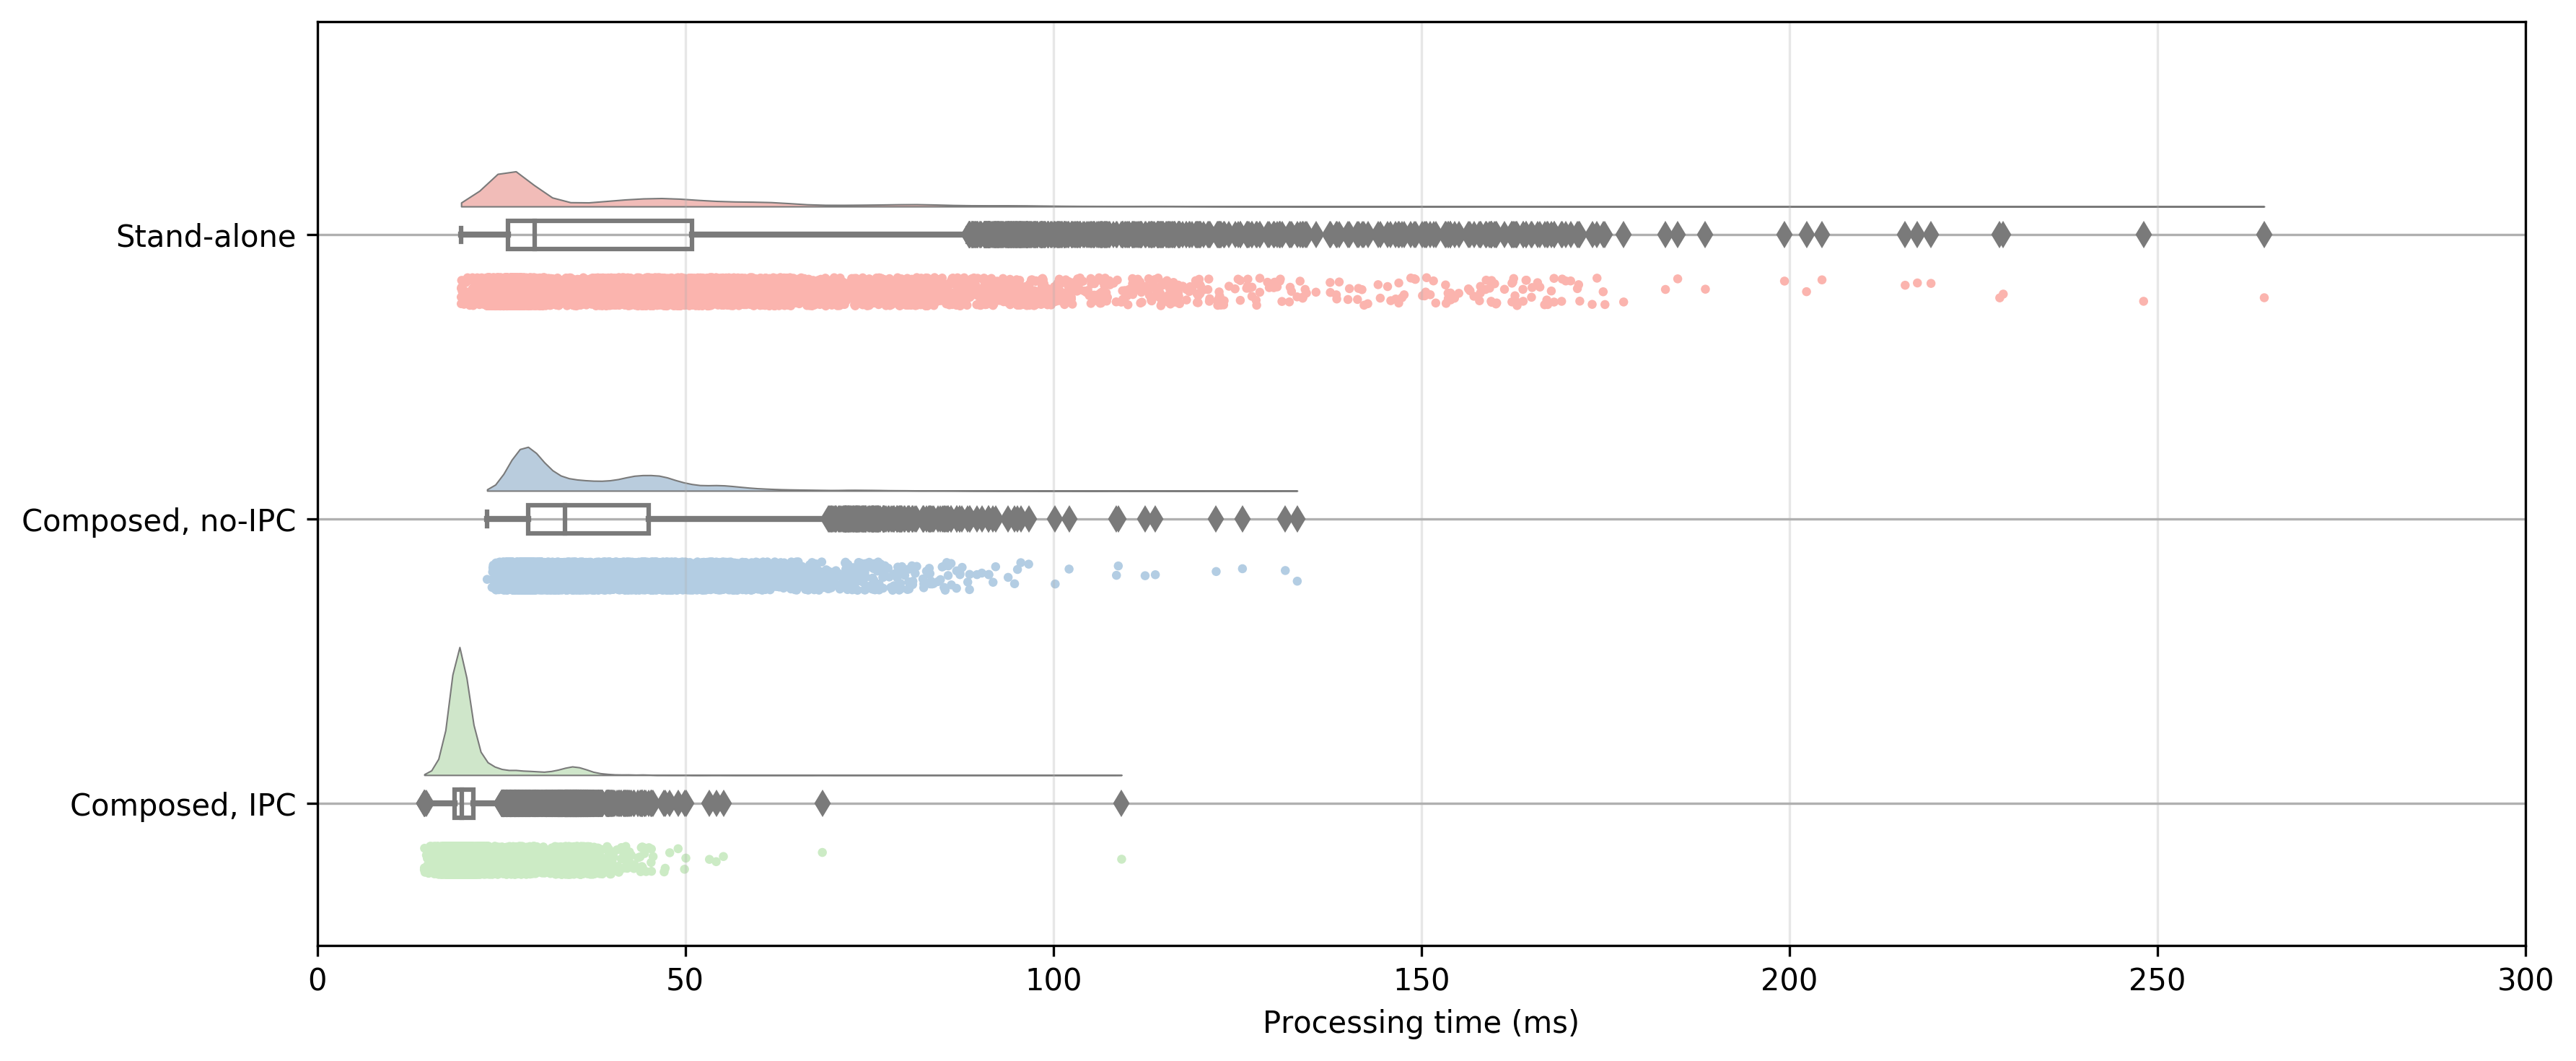

In [34]:
pt.RainCloud(data=df, x='x', y='y', bw = 0.1, palette='Pastel1',
             linewidth=0.5,
             width_viol = .9,
             jitter=.05,
             width_box = .1,
             offset= .1,
             figsize = (12,5), orient = 'h',
             move = .2)
plt.xlim((0, 300))
# remove for better include in Paper
#plt.title("Distribution of image processing time")
plt.xlabel("Processing time (ms)")
plt.ylabel(None)
plt.grid(axis='y')
plt.grid(axis='x', alpha=.3)
plt.tight_layout()
plt.savefig("standalone-vs-composed-with-motion.pdf")

In [35]:
print(f"Median time, stand-alone: {np.median(standalone_dts_sample)}ms")
print(f"Median time, composed, no-IPC: {np.median(composed_noipc_dts_sample)}ms")
print(f"Median time, composed: {np.median(composed_dts_sample)}ms")

Median time, stand-alone: 29.5953785ms
Median time, composed, no-IPC: 33.631963999999996ms
Median time, composed: 19.694516ms


In [36]:
print(f"Mean time, stand-alone: {np.mean(standalone_dts_sample)}ms")
print(f"Mean time, composed, no-IPC: {np.mean(composed_noipc_dts_sample)}ms")
print(f"Mean time, composed: {np.mean(composed_dts_sample)}ms")

Mean time, stand-alone: 42.0896132668ms
Mean time, composed, no-IPC: 37.7431609265ms
Mean time, composed: 21.337300946200003ms
